# ARIMA Models

In [1]:
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sktime import datasets
import pmdarima as pm
from pmdarima.model_selection import train_test_split

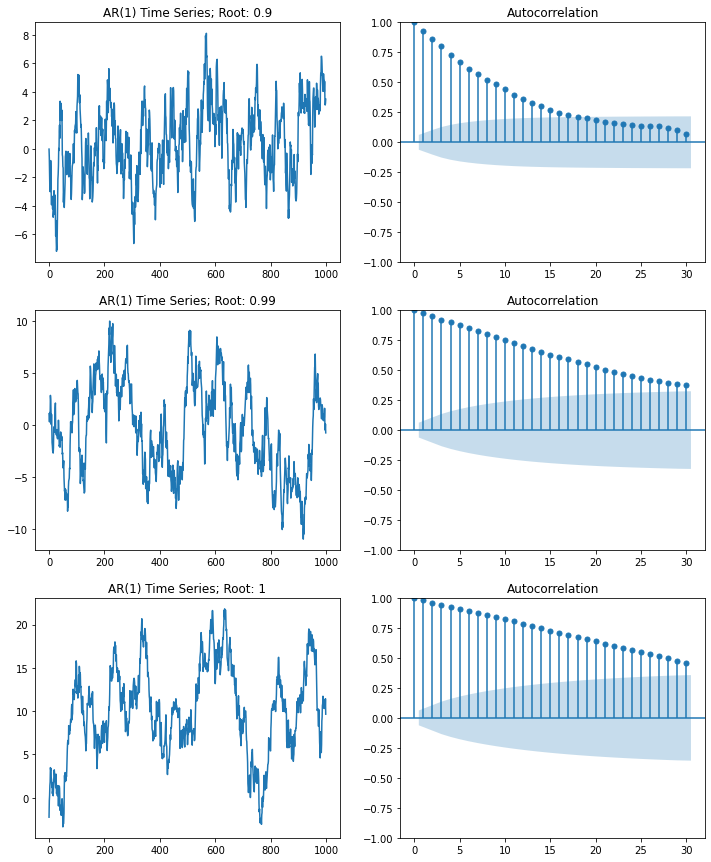

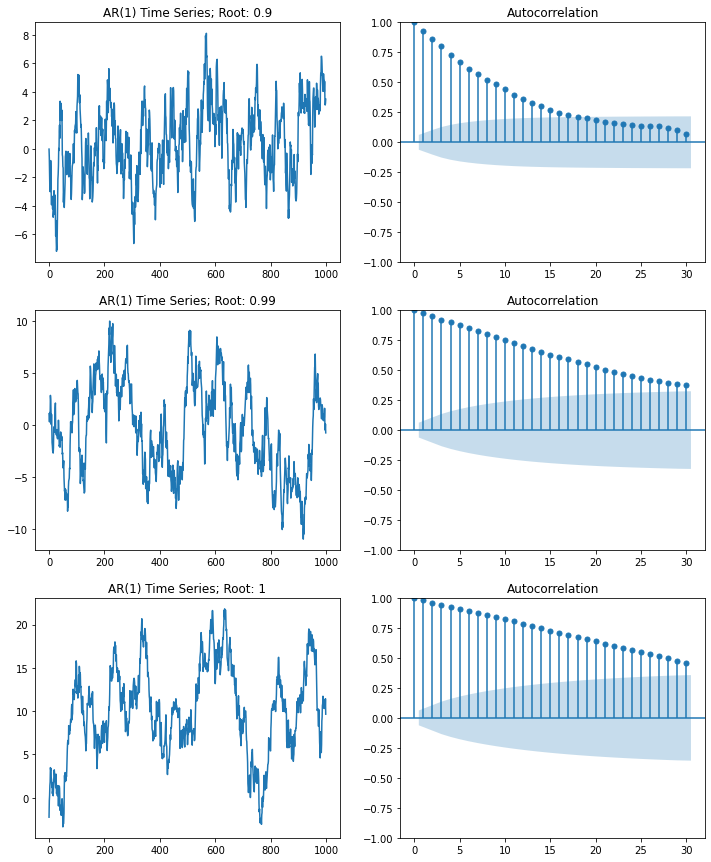

In [2]:
# due to randomness series with change in following plots

# generate some series
ts1 = sm.tsa.arma_generate_sample([1,-0.9],[1],1000, burnin=100)
ts2 = sm.tsa.arma_generate_sample([1,-0.97],[1],1000, burnin=100)
ts3 = sm.tsa.arma_generate_sample([1,-1],[1],1000, burnin=100)
# plot the series and autocorrelation
fig, ax = plt.subplots(3, 2, figsize=(12, 15));
ax[0,0].plot(ts1); ax[0,0].set_title("AR(1) Time Series; Root: 0.9")
ax[1,0].plot(ts2); ax[1,0].set_title("AR(1) Time Series; Root: 0.99")
ax[2,0].plot(ts3); ax[2,0].set_title("AR(1) Time Series; Root: 1")
sm.graphics.tsa.plot_acf(ts1, ax=ax[0,1])
sm.graphics.tsa.plot_acf(ts2, ax=ax[1,1])
sm.graphics.tsa.plot_acf(ts3, ax=ax[2,1])
#fig.savefig('./unit_roots.png', dpi=300);

In [3]:
y_macro_economic = datasets.load_macroeconomic()
y_airline = datasets.load_airline()

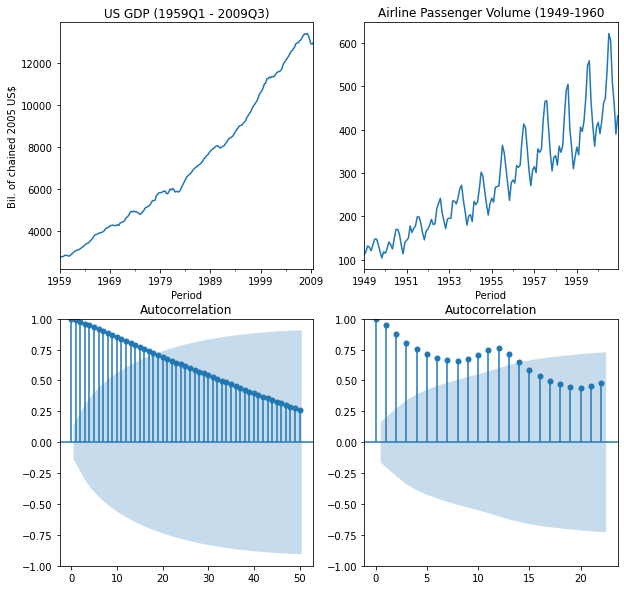

In [4]:
fig, ((gdp, airline), (gdp_acf, airline_acf)) = plt.subplots(2, 2, figsize=(10, 10));
ax_gdp = y_macro_economic.realgdp.plot(ax=gdp)
ax_gdp.set_title('US GDP (1959Q1 - 2009Q3)');
ax_gdp.set_ylabel('Bil. of chained 2005 US$');
plot = sm.graphics.tsa.plot_acf(y_macro_economic.realgdp, lags=50, ax=gdp_acf)
ax_airline = y_airline.plot(ax=airline);
ax_airline.set_title('Airline Passenger Volume (1949-1960');
sm.graphics.tsa.plot_acf(y_airline.values, ax=airline_acf);
fig.savefig('./gdp_airline_plots', dpi=300)

## ARIMA

### Fitting the model

Approach

* determine the difference order to stationarize the series
* fit an ARMA model to the differenced data

We'll use the ADF test as a criteria for how many differences to take.

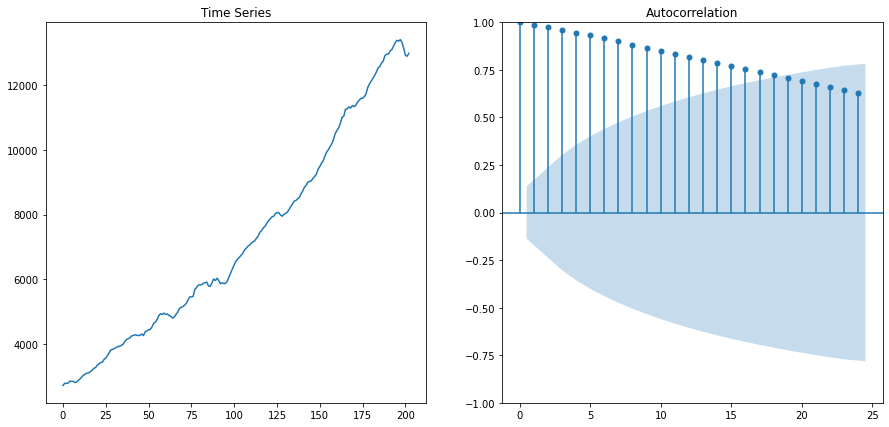

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(y_macro_economic.realgdp.values)
ax[0].set_title("Time Series")
sm.graphics.tsa.plot_acf(y_macro_economic.realgdp.values, ax=ax[1])
plt.show()
fig.savefig('./arima_series.png', dpi=300)

In [6]:
adf_test = pm.arima.ADFTest()
adf_test.should_diff(y_macro_economic.realgdp.values)

(0.7423236714537164, True)

In [7]:
first_diff = np.diff(y_macro_economic.realgdp.values, n=1)
adf_test.should_diff(first_diff)

(0.01, False)

Based on the ADF test, it looks like we only need to make one difference.

The differenced data series and its autocorrelation plot is shown below.
The series resulting from the first difference appears to be stationary based on the plots.
Based on the autocorrelation plot, the differenced series appears to be consistent with an AR(2).

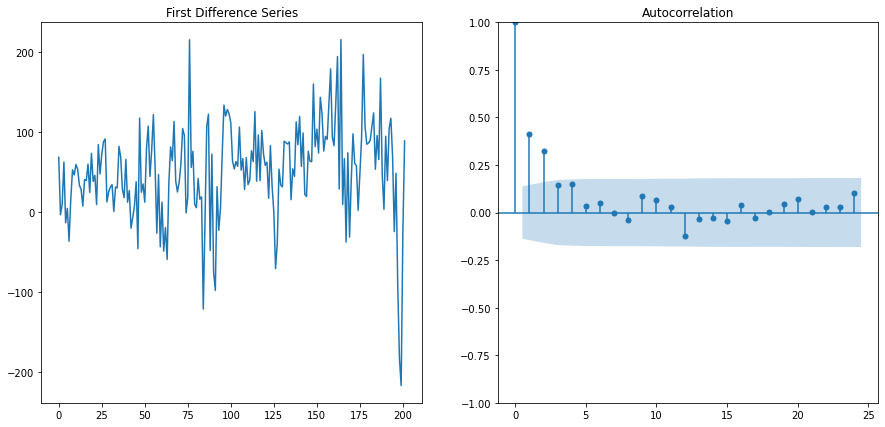

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(first_diff)
ax[0].set_title('First Difference Series')
sm.graphics.tsa.plot_acf(first_diff, ax=ax[1])
plt.show()
#fig.savefig('./arima_first_diff.png', dpi=300)

In [9]:
# we can also use ndiffs to determine how many differences to take
pm.arima.ndiffs(y_macro_economic.realgdp.values, test='adf')

1

We will now use an automated method for fitting an ARMA model to the resulting series.
`auto_arima` can be used to fit the entire ARIMA model,
but we will use it to fit the ARMA porition since we already know the difference order.
`auto_arima` will fit several models and return the model that fits best based on `AIC`.
`auto_arima` has many configurtion options.
The config options can be found here:  
[http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima)

In [10]:
arima = pm.auto_arima(
    first_diff, error_action='ignore', trace=True, 
    suppress_warnings=True, maxiter=5, seasonal=False, 
    test='adf'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2207.388, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2338.346, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2226.760, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2284.220, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2206.365, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2253.267, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2203.917, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2208.521, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2208.726, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2193.482, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2208.669, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2195.212, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2191.810, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2190.196, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept

In [11]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  202
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1091.098
Date:                Mon, 16 Jan 2023   AIC                           2190.196
Time:                        11:24:55   BIC                           2203.429
Sample:                             0   HQIC                          2195.550
                                - 202                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.5559      4.241      5.791      0.000      16.244      32.867
ar.L1          0.3320      0.055      6.066      0.000       0.225       0.439
ar.L2          0.1859      0.055      3.406      0.001       0.079       0.293
sigma2      2884.2154    234.151     12.318      0.000    2425.288    3343.143
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                17.30
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARMA model fit of the differenced data is AR(2).
This means the model we found for the original series is ARIMA(2,1,0).

### Forecasting

In [12]:
train, test = train_test_split(y_macro_economic.realgdp.values, train_size=0.9)
arima = pm.auto_arima(
    train, out_of_sample_size=10, 
    suppress_warnings=True, error_action='ignore', 
    test='adf'
)
preds, conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)

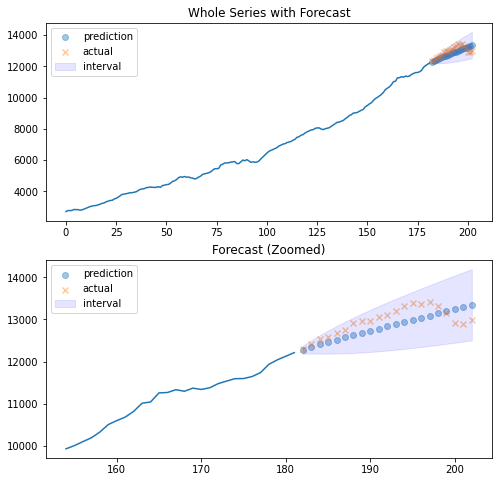

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train)
axes[0].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o', label='prediction')
axes[0].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x', label='actual')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b', label='interval')
axes[0].set_title("Whole Series with Forecast")
axes[0].legend(loc=2)

zoom_idx = int(train.shape[0]*0.85)
axes[1].plot(x_axis[zoom_idx:train.shape[0]], train[zoom_idx:])
axes[1].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o', label='prediction')
axes[1].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x', label='actual')
axes[1].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b', label='interval')
axes[1].set_title("Forecast (Zoomed)")
axes[1].legend(loc=2);
#fig.savefig('arima_forecast.png', dpi=300)

## Seasonal ARIMA

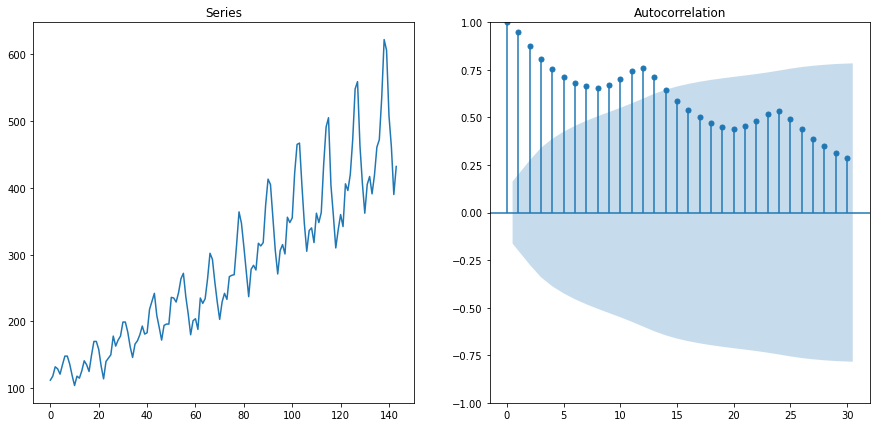

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(y_airline.values)
ax[0].set_title('Series')
sm.graphics.tsa.plot_acf(y_airline.values, ax=ax[1], lags=30)
plt.show()
#fig.savefig('airline_data.png', dpi=300)

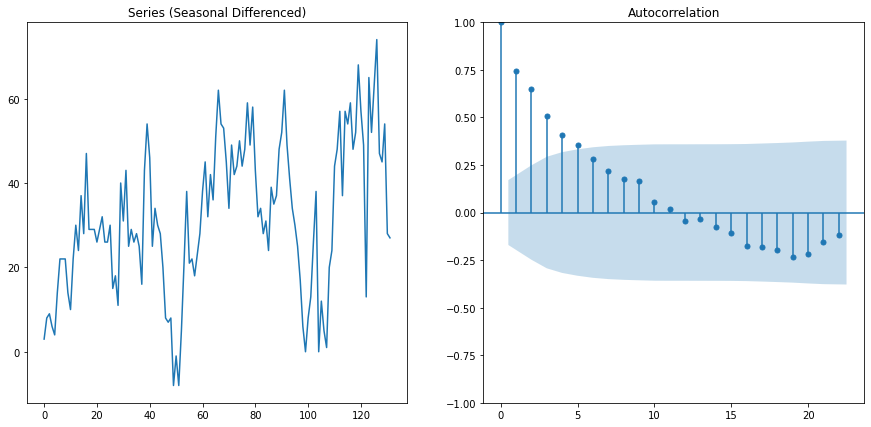

In [15]:
series = pm.utils.diff( y_airline.values, lag=12)
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(series)
ax[0].set_title('Series (Seasonal Differenced)')
sm.graphics.tsa.plot_acf(series, ax=ax[1])
plt.show()
#fig.savefig('seasonal_diffed.png')

In [16]:
adf_test = pm.arima.ADFTest()
adf_test.should_diff(series)

(0.09898694171553156, True)

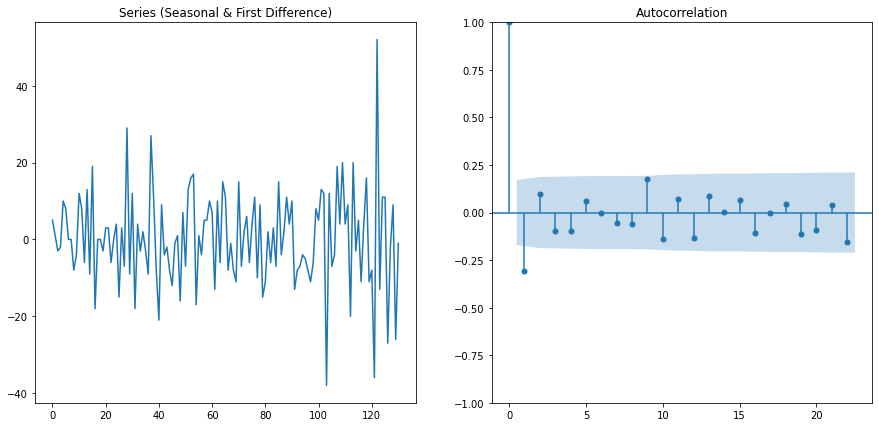

In [17]:
series = pm.utils.diff(series)
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(series)
ax[0].set_title('Series (Seasonal & First Difference)')
sm.graphics.tsa.plot_acf(series, ax=ax[1])
plt.show()
fig.savefig('seasonal_and_first_diff.png', dpi=300)

In [18]:
adf_test = pm.arima.ADFTest()
adf_test.should_diff(series)

(0.01, False)

In [19]:
pm.auto_arima(
    series, error_action='ignore', trace=False,
    suppress_warnings=True, maxiter=5, seasonal=False,
    test='adf'
)

ARIMA(maxiter=5, order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [20]:
sarima = pm.auto_arima(
    y_airline.values, error_action='ignore', trace=True,
    suppress_warnings=True, maxiter=5, seasonal=True, m=12,
    test='adf'
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1024.414, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.395, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.096, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.394, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1020.928, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1021.675, Time=0.07 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.397, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.397, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1020.639, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1024.386, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=1022.344, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.533 seconds


In [21]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -508.197
Date:                            Mon, 16 Jan 2023   AIC                           1020.394
Time:                                    11:24:59   BIC                           1026.145
Sample:                                         0   HQIC                          1022.731
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3059      0.074     -4.148      0.000      -0.450      -0.161
sigma2       137.3695     14.701      9.344      0.000     108.555     166.184
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.83
Prob(Q):                              0.96   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                             0.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecasting SARIMA

In [22]:
train, test = train_test_split(y_airline.values, train_size=0.9)
sarima = pm.auto_arima(
    train, error_action='ignore', trace=True,
    suppress_warnings=True, maxiter=5, seasonal=True, m=12,
    test='adf'
)
preds, conf_int = sarima.predict(n_periods=test.shape[0], return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=883.801, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=881.901, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=877.922, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=878.982, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=876.776, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=878.105, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=879.927, Time=0.07 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=877.995, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=877.681, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=877.710, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=880.213, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=878.415, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.492 seconds


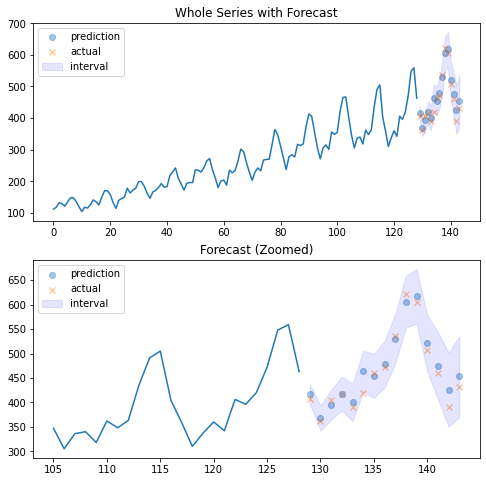

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train)
axes[0].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o', label='prediction')
axes[0].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x', label='actual')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b', label='interval')
axes[0].set_title("Whole Series with Forecast")
axes[0].legend(loc=2)

zoom_idx = int(train.shape[0]*0.82)
axes[1].plot(x_axis[zoom_idx:train.shape[0]], train[zoom_idx:])
axes[1].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o', label='prediction')
axes[1].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x', label='actual')
axes[1].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b', label='interval')
axes[1].set_title("Forecast (Zoomed)")
axes[1].legend(loc=2);
#fig.savefig('aruma_forecast.png', dpi=300)

## Decomposition

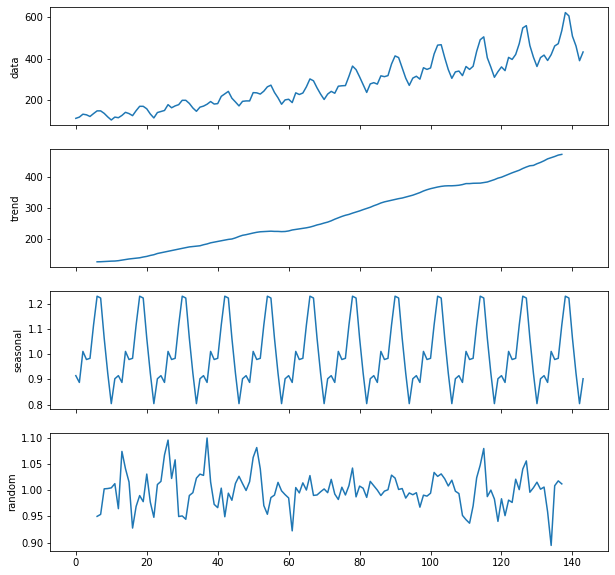

In [24]:
decomposed = pm.arima.decompose(y_airline.values, type_='multiplicative', m=12)
pm.utils.visualization.decomposed_plot(decomposed, figure_kwargs={'figsize': (10, 10)})